In [80]:
options(warn = -1, verbose=FALSE)
#!/usr/bin/env Rscript 
library(dplyr)
library(httr)
library(pheatmap)
library(ggplot2)
library(unixtools)
library(repr)
library(ggmin)
library(purrr)
library(geojsonio)
library(circlize)
library(pryr)
set_config(config(ssl_verifypeer = 0L))
ulimit::memory_limit(100000)
set.tempdir("/datastore/lucy/tmp/")
setwd("/datastore/lucy/CosMx")

soft  hard 
1e+05   Inf

## Load Korsunksy lab functions

In [81]:
source("./R/utils.R")
start_upR(TRUE)
source("./R/TissueSegFunctions.R")

## Load cell geometry and annotations

In [82]:
objH<-readRDS("./cache/tissueSegmentation/spatialObjregions.RDS")

In [83]:
head(objH$metadata)

SampleFOV,SampleID,FOV,cellID,cell,area_um,radius_um,cell_center_x,cell_center_y,pxsize,⋯,PatientID,Condition,new.coarse.types,fine.types,Clust0.1,Clust0.5,Clust0.7,Clust1,Clust2,highres.regions
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<ord>,<ord>,<chr>,<chr>,<chr>,<chr>,<chr>,<ord>
Active RA_Run5654_399G0_32G77_F001,Run5654_399G0_32G77,F001,C18_Run5654_399G0_32G77_F001,18,20.97153,2.583688,23171.10,-1512.382,0.168,⋯,32G77,Active RA,Fibroblast,Stromal_THY1+COL1A1+ FLS,0,2,2,0,6,Sublining
Active RA_Run5654_399G0_32G77_F001,Run5654_399G0_32G77,F001,C26_Run5654_399G0_32G77_F001,26,42.90907,3.695725,23342.02,-1654.621,0.168,⋯,32G77,Active RA,Macrophage,Myeloid_FOLR2highLYVE1+ STM,0,1,1,2,7,Myeloid-rich Lining
Active RA_Run5654_399G0_32G77_F001,Run5654_399G0_32G77,F001,C27_Run5654_399G0_32G77_F001,27,17.77128,2.378397,23361.90,-1671.197,0.168,⋯,32G77,Active RA,Macrophage,Myeloid_SPP1+TREM2low STM,0,1,1,2,7,Myeloid-rich Lining
Active RA_Run5654_399G0_32G77_F001,Run5654_399G0_32G77,F001,C28_Run5654_399G0_32G77_F001,28,32.12423,3.197727,23353.14,-1664.544,0.168,⋯,32G77,Active RA,cDC,Myeloid_iDC3 CD14highCD163+,0,1,1,2,7,Myeloid-rich Lining
Active RA_Run5654_399G0_32G77_F001,Run5654_399G0_32G77,F001,C29_Run5654_399G0_32G77_F001,29,15.89895,2.249621,23232.99,-1540.613,0.168,⋯,32G77,Active RA,NA,NA,1,0,0,1,2,TGFB+ Myeloid-rich
Active RA_Run5654_399G0_32G77_F001,Run5654_399G0_32G77,F001,C32_Run5654_399G0_32G77_F001,32,47.80699,3.900953,23372.56,-1680.999,0.168,⋯,32G77,Active RA,PRG4+ Lining Fibroblast,Stromal_PRG4+ lining FLS,0,4,4,4,8,PRG4+ FLS Lining


In [84]:
niche_anno<-objH$metadata %>% dplyr::select(cellID,highres.regions) 
head(niche_anno)

cellID,highres.regions
<chr>,<ord>
C18_Run5654_399G0_32G77_F001,Sublining
C26_Run5654_399G0_32G77_F001,Myeloid-rich Lining
C27_Run5654_399G0_32G77_F001,Myeloid-rich Lining
C28_Run5654_399G0_32G77_F001,Myeloid-rich Lining
C29_Run5654_399G0_32G77_F001,TGFB+ Myeloid-rich
C32_Run5654_399G0_32G77_F001,PRG4+ FLS Lining


In [85]:
rm(objH)

In [86]:
cellgeoms<-readRDS("./cache/raw/Glasgow_cellgeoms_QC.RDS") 

In [87]:
head(cellgeoms, 2)

,cellID,cell,SampleID,FOV,area_um,radius_um,center_x,centroid,shape,center_y
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<POINT>,<MULTIPOLYGON>,<dbl>
1,C18_Run5654_399G0_32G77_F001,18,Run5654_399G0_32G77,F001,20.97153,2.583688,137923.2,POINT (137923.2 -9002.276),MULTIPOLYGON (((137929.8 -9...,-9002.276
2,C26_Run5654_399G0_32G77_F001,26,Run5654_399G0_32G77,F001,42.90907,3.695725,138940.6,POINT (138940.6 -9848.937),MULTIPOLYGON (((138952.2 -9...,-9848.937


In [88]:
cell_ann<-readRDS("cache/CosMxcoarseGrainharmonyObj_markers.RDS")$metadata

In [89]:
head(cell_ann, 2)

cellID,cell,SampleFOV,x,y,density,elongation,area,avg_confidence,nGene,nCounts,nNeg,celltype.coarse,type_harmony,new.coarse.types,fine.types,type_harmony_clean
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<ord>,<chr>,<chr>
C18_Run5654_399G0_32G77_F001,18,Run5654_399G0_32G77_F001,137923.1,-9002.730,0.04920,1.771,914.6,0.8723,30,45,0,Fibroblasts,Stromal_THY1+COL1A1+ FLS,Fibroblast,Stromal_THY1+COL1A1+ FLS,NA
C26_Run5654_399G0_32G77_F001,26,Run5654_399G0_32G77_F001,138939.9,-9848.455,0.08075,7.536,1610.0,0.9934,87,130,0,Myeloid,Myeloid_FOLR2highLYVE1+ STM,Macrophage,Myeloid_FOLR2highLYVE1+ STM,Myeloid_FOLR2highLYVE1+ STM


In [90]:
cell_ann <- cell_ann %>% left_join(niche_anno, by = "cellID")

In [91]:
head(cell_ann, 2)

cellID,cell,SampleFOV,x,y,density,elongation,area,avg_confidence,nGene,nCounts,nNeg,celltype.coarse,type_harmony,new.coarse.types,fine.types,type_harmony_clean,highres.regions
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<ord>,<chr>,<chr>,<ord>
C18_Run5654_399G0_32G77_F001,18,Run5654_399G0_32G77_F001,137923.1,-9002.730,0.04920,1.771,914.6,0.8723,30,45,0,Fibroblasts,Stromal_THY1+COL1A1+ FLS,Fibroblast,Stromal_THY1+COL1A1+ FLS,NA,Sublining
C26_Run5654_399G0_32G77_F001,26,Run5654_399G0_32G77_F001,138939.9,-9848.455,0.08075,7.536,1610.0,0.9934,87,130,0,Myeloid,Myeloid_FOLR2highLYVE1+ STM,Macrophage,Myeloid_FOLR2highLYVE1+ STM,Myeloid_FOLR2highLYVE1+ STM,Myeloid-rich Lining


In [92]:
unique(cell_ann$fine.types)

[1] "Stromal_THY1+COL1A1+ FLS"             
 [2] "Myeloid_FOLR2highLYVE1+ STM"          
 [3] "Myeloid_SPP1+TREM2low STM"            
 [4] "Myeloid_iDC3 CD14highCD163+"          
 [5] "Stromal_PRG4+ lining FLS"             
 [6] "Tcell_MYOM2+ NK/STM doublet"          
 [7] "Myeloid_TREM2+LPL+ STM"               
 [8] "Stromal_CCL21+LYVE1+ lymphatic EC"    
 [9] "Tcell_CCL5+CXCR6+MAF+ TPH"            
[10] "Myeloid_DC3/FLS doublet"              
[11] "Myeloid_TNF+ICAM1+ STM"               
[12] "Myeloid_TREM2+ STM"                   
[13] "Myeloid_ISG15+CXCL10+ STM"            
[14] "Myeloid_DC3 CD1clowCD163+"            
[15] "Stromal_PRG4+MMP3+ lining FLS"        
[16] "Stromal_ICAM1+CLU+ venular EC"        
[17] "Myeloid_BIRC5+ cycling STM"           
[18] "Plasma"                               
[19] "Myeloid_SPP1+ STM"                    
[20] "Myeloid_HBA1+CLEC9A+ DC1"             
[21] "Stromal_NOTCH3+MCAM+ mural cells"     
[22] "Tcell_T/FLS doublet"                  
[23] "Myeloid_FOLR2highCLEC10A+ STM"        
[24] "Tcell_GZMK+CCL5+CD8A+ TEM"            
[25] "B cells"                              
[26] "Stromal_THY1+CXCL12+ FLS"             
[27] "Stromal_THY1+CXCL12+IGHG1+ FLS"       
[28] "Tcell_CCL5+GZMA+CD4+ TEM"             
[29] "Stromal_NOTCH4+ arteriolar EC"        
[30] "Myeloid_DC2 CD1c+"                    
[31] "Tcell_KLRC2+ NK"                      
[32] "Myeloid_FOLR2+ STM/FLS doublet"       
[33] "Myeloid_FOLR2highEGR1+ STM"           
[34] "Stromal_SPARC+ capillary EC"          
[35] "Tcell_MYOM2+ NK"                      
[36] "Myeloid_CD14highS100A12+ monoSTM"     
[37] "Myeloid_CLEC10A+ATF3+ STM"            
[38] "Stromal_C1QA+ FLS doublets"           
[39] "Tcell_CD55+PDE4B+CD4+ Naive"          
[40] "Stromal_THY1+CD34+MFAP5+ FLS"         
[41] "Tcell_CXCL13hi MAF+ TPH"              
[42] "Myeloid_DC2 CCR7+"                    
[43] "Mast"                                 
[44] "Tcell_T/C1QA doublet"                 
[45] "Tcell_GZMK+CCL5+CD8A+/FLS doublet"    
[46] "Tcell_CCL5+CD8B+CD8A+ Naive"          
[47] "Stromal_CYP1B1+CD52+ FLS"             
[48] "Tcell_BAG3+DNAJB1+CD4+ T"             
[49] "Tcell_T/immune doublet"               
[50] "Stromal_THY1+GAS6+CXCL14+ FLS"        
[51] "Tcell_CCR7+CD7+CD4+ Naive/TCM"        
[52] "Myeloid_FOLR2+ STM/FLS/Plasma doublet"
[53] "Tcell_low counts"                     
[54] "Tcell_FOXP3+ Tregs"                   
[55] "Tcell_KLRB1+GZMK+ NKT"                
[56] "Myeloid_FOLR2+ STM/Bcell doublet"     
[57] "Myeloid_TGFB2+BIRC5+ STM"             
[58] "Myeloid_FCGR3A+ monoSTM"              
[59] "Stromal_NA"                           
[60] "Tcell_CCR6+RORA+TNFSF13B+ TEM"        
[61] "Tcell_XCL1+ NK"                       
[62] "Adipocytes"                           
[63] "Myeloid"                              
[64] "Myeloid_DC1 CLEC9A+"                  
[65] "DC"                                   
[66] "Fibroblasts"

In [93]:
sampleFOVcondition <- read.table("/datastore/lucy/CosMx/cache/SampleFOV-condition.csv", header=TRUE, sep=",")

In [94]:
#Combine with info about condition of each FOV
cellgeoms <- merge(cellgeoms, sampleFOVcondition, all=FALSE)
cell_ann <- merge(cell_ann, sampleFOVcondition, all=FALSE)

In [95]:
cellgeoms$SampleFOV <- paste0(cellgeoms$Condition,"_",cellgeoms$SampleFOV)
cell_ann$SampleFOV <- paste0(cell_ann$Condition,"_",cell_ann$SampleFOV)

In [96]:
pixel_size <- (0.18^2) #This is incorrect

In [97]:
pixel_size

[1] 0.0324

In [98]:
mean(cellgeoms$area_um) 

[1] 40.95227

# Run co-localization

## Function

In [99]:
coloc_one_type = function(index_type, adj, y, nperm = 100, max_dist=30, compartments=NULL, verbose=TRUE) {
    if (verbose) message(index_type)
    types = unique(y)
    i_index = which(y == index_type)
    i_shuffle = setdiff(seq_len(length(y)), i_index)
          
    X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+y) %>% as.matrix()

    colnames(X) = gsub('^y', '', colnames(X))
    freq = (colSums(X) / nrow(X))[types]
    freq_perm = map(seq_len(nperm), function(i) {
        set.seed(i)
        yperm = y
        if (is.null(compartments)) {
            yperm[i_shuffle] = sample(y[i_shuffle])
        } else {
            ## shuffle inside compartments, to preserve total composition within compartment
            .x = split(i_shuffle, compartments[i_shuffle]) %>%
                map(function(.i) {
                    ## CAUTION: if .i is a single number, sample will interpret it as 1:.i
                    if (length(.i) == 1) {
                        message("No shuffling is taking place, check code")
                        res = .i
                    } else {
                        res = sample(.i) ## shuffle non-index cells inside hub            
                    }
                   
                    names(res) = .i
                    return(res)
                }) %>%
                reduce(c)
            yperm[as.integer(names(.x))] <- y[.x]
        }

        X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+yperm) %>% as.matrix() #%>% prop.table(1)
        colnames(X) = gsub('^yperm', '', colnames(X))
        (colSums(X) / nrow(X))[types]    
    }) %>%
        purrr::reduce(rbind2)

    stats = tibble(
        type = types,
        freq,
        zscore = (freq - apply(freq_perm, 2, mean)) / apply(freq_perm, 2, sd),
        pval = exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed
        fdr = p.adjust(pval)
    ) %>%
        cbind(dplyr::rename(data.frame(t(apply(freq_perm, 2, quantile, c(.025, .975)))), q025 = `X2.5.`, q975 = `X97.5.`)) %>% ## 95% CI
        subset(type != index_type) %>%
        dplyr::mutate(index_type = index_type) %>%
        dplyr::select(index_type, type, everything()) %>%
        arrange(fdr)

    return(stats) 
}


coloc_all_types = function(index_types, coords, y, nperm = 100, nsteps=1, max_dist=30, compartments=NULL, parallel=TRUE, verbose=TRUE) {
    if (parallel & length(index_types) > 1) {
        plan(multicore)
    } else {
        plan(sequential)
    }

    ## Define neighbors
    ## NOTE: max_dist only refers to directly adjacent neighbors
    adj = spatula::getSpatialNeighbors(coords, return_weights = TRUE)
    adj@x[adj@x > max_dist] = 0
    adj = Matrix::drop0(adj)
    adj@x = rep(1, length(adj@x))
   
    ## If nsteps>1, consider not only your adjacent neighbors
    ##   but also your neighbor's neighbors etc.
    if (nsteps > 1) {
        adj = adj + Matrix::Diagonal(n = nrow(adj)) ## add self
        for (iter in seq_len(nsteps - 1)) {
            adj = adj %*% adj
        }
        ## Ignore weights. Only care if cell is a neighbor or not
        adj@x = rep(1, length(adj@x))
       
        ## Remove self as neighbor
        adj = adj - Matrix::Diagonal(n = nrow(adj))
        adj = Matrix::drop0(adj)
    }
       
    index_types %>%
        future_map(coloc_one_type, adj, y, nperm, max_dist, compartments, verbose, .options = furrr::furrr_options(seed = 1)) %>%
        rbindlist()  %>% 
        identity
}

## Execute

For each FOV, an cell x cell adjacency matrix is created using getSpatialNeighbours(). Specifying the number of 'steps' determines how far out you consider as neighbours for cell of interest i.e. more steps, more neighbours. 

In [100]:
cell_ann$dc.t <- ifelse(cell_ann$fine.types%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM',"Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs'), as.character(cell_ann$fine.types), as.character(cell_ann$new.coarse.types))

In [101]:
unique(cell_ann$dc.t)

[1] "Fibroblast"                    "Macrophage"                   
 [3] "Myeloid_iDC3 CD14highCD163+"   "PRG4+ Lining Fibroblast"      
 [5] NA                              "Endothelial"                  
 [7] "Tcell_CCL5+CXCR6+MAF+ TPH"     "Myeloid_DC3 CD1clowCD163+"    
 [9] "Plasma"                        "cDC"                          
[11] "Mural"                         "CD4+ Tcell"                   
[13] "Myeloid_FOLR2highCLEC10A+ STM" "CD8+ Tcell"                   
[15] "B cells"                       "Tcell_CCL5+GZMA+CD4+ TEM"     
[17] "Myeloid_DC2 CD1c+"             "NK cell"                      
[19] "Tcell_CD55+PDE4B+CD4+ Naive"   "Tcell_CXCL13hi MAF+ TPH"      
[21] "Myeloid_DC2 CCR7+"             "Mast"                         
[23] "Tcell_BAG3+DNAJB1+CD4+ T"      "Tcell_CCR7+CD7+CD4+ Naive/TCM"
[25] "Tcell_FOXP3+ Tregs"            "Tcell_CCR6+RORA+TNFSF13B+ TEM"
[27] "Adipocytes"                    "Myeloid_DC1 CLEC9A+"

In [102]:
cell_ann$dc.t <- as.ordered(factor(cell_ann$dc.t, 
                        levels=c("Adipocytes","PRG4+ Lining Fibroblast","Fibroblast",
                                 "Mural","Endothelial","Plasma","B cells",
                                 "Tcell_CD55+PDE4B+CD4+ Naive","Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs',"CD8+ Tcell","NK cell","Mast","Macrophage",
                                 'Myeloid_FOLR2highCLEC10A+ STM','Myeloid_iDC3 CD14highCD163+','Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_DC2 CD1c+','Myeloid_DC2 CCR7+','Myeloid_DC1 CLEC9A+'
                                 )))

In [103]:
levels(cell_ann$dc.t)

[1] "Adipocytes"                    "PRG4+ Lining Fibroblast"      
 [3] "Fibroblast"                    "Mural"                        
 [5] "Endothelial"                   "Plasma"                       
 [7] "B cells"                       "Tcell_CD55+PDE4B+CD4+ Naive"  
 [9] "Tcell_CCR7+CD7+CD4+ Naive/TCM" "Tcell_BAG3+DNAJB1+CD4+ T"     
[11] "Tcell_CCR6+RORA+TNFSF13B+ TEM" "Tcell_CCL5+GZMA+CD4+ TEM"     
[13] "Tcell_CCL5+CXCR6+MAF+ TPH"     "Tcell_CXCL13hi MAF+ TPH"      
[15] "Tcell_FOXP3+ Tregs"            "CD8+ Tcell"                   
[17] "NK cell"                       "Mast"                         
[19] "Macrophage"                    "Myeloid_FOLR2highCLEC10A+ STM"
[21] "Myeloid_iDC3 CD14highCD163+"   "Myeloid_DC3 CD1clowCD163+"    
[23] "Myeloid_DC2 CD1c+"             "Myeloid_DC2 CCR7+"            
[25] "Myeloid_DC1 CLEC9A+"

In [104]:
plan(multicore, workers=10)

# Active RA only 

In [105]:
activeRA_cell_ann <- cell_ann[which(cell_ann$Condition%in%"Active RA"),]

In [106]:
activeRA_cell_ann <- activeRA_cell_ann[which(!is.na(activeRA_cell_ann$dc.t)),]

In [107]:
unique(activeRA_cell_ann$dc.t)

[1] Fibroblast                    Macrophage                   
 [3] Myeloid_iDC3 CD14highCD163+   PRG4+ Lining Fibroblast      
 [5] Endothelial                   Tcell_CCL5+CXCR6+MAF+ TPH    
 [7] Myeloid_DC3 CD1clowCD163+     Plasma                       
 [9] Mural                         Myeloid_FOLR2highCLEC10A+ STM
[11] CD8+ Tcell                    B cells                      
[13] Tcell_CCL5+GZMA+CD4+ TEM      Myeloid_DC2 CD1c+            
[15] NK cell                       Tcell_CD55+PDE4B+CD4+ Naive  
[17] Tcell_CXCL13hi MAF+ TPH       Myeloid_DC2 CCR7+            
[19] Mast                          Tcell_BAG3+DNAJB1+CD4+ T     
[21] Tcell_CCR7+CD7+CD4+ Naive/TCM Tcell_FOXP3+ Tregs           
[23] Tcell_CCR6+RORA+TNFSF13B+ TEM Adipocytes                   
[25] Myeloid_DC1 CLEC9A+          
25 Levels: Adipocytes < PRG4+ Lining Fibroblast < Fibroblast < ... < Myeloid_DC1 CLEC9A+

In [29]:
coloc_one_type

function(index_type, adj, y, nperm = 100, max_dist=30, compartments=NULL, verbose=TRUE) {
    if (verbose) message(index_type)
    types = unique(y)
    i_index = which(y == index_type)
    i_shuffle = setdiff(seq_len(length(y)), i_index)
          
    X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+y) %>% as.matrix()

    colnames(X) = gsub('^y', '', colnames(X))
    freq = (colSums(X) / nrow(X))[types]
    freq_perm = map(seq_len(nperm), function(i) {
        set.seed(i)
        yperm = y
        if (is.null(compartments)) {
            yperm[i_shuffle] = sample(y[i_shuffle])
        } else {
            ## shuffle inside compartments, to preserve total composition within compartment
            .x = split(i_shuffle, compartments[i_shuffle]) %>%
                map(function(.i) {
                    ## CAUTION: if .i is a single number, sample will interpret it as 1:.i
                    if (length(.i) == 1) {
                        message("No shuffling is taking place, check code")
                        res = .i
                    } else {
                        res = sample(.i) ## shuffle non-index cells inside hub            
                    }
                   
                    names(res) = .i
                    return(res)
                }) %>%
                reduce(c)
            yperm[as.integer(names(.x))] <- y[.x]
        }

        X = adj[i_index, ] %*% Matrix::sparse.model.matrix(~0+yperm) %>% as.matrix() #%>% prop.table(1)
        colnames(X) = gsub('^yperm', '', colnames(X))
        (colSums(X) / nrow(X))[types]    
    }) %>%
        purrr::reduce(rbind2)

    stats = tibble(
        type = types,
        freq,
        zscore = (freq - apply(freq_perm, 2, mean)) / apply(freq_perm, 2, sd),
        pval = exp(pnorm(-zscore, log.p = TRUE, lower.tail = TRUE)), ## one-tailed
        fdr = p.adjust(pval)
    ) %>%
        cbind(dplyr::rename(data.frame(t(apply(freq_perm, 2, quantile, c(.025, .975)))), q025 = `X2.5.`, q975 = `X97.5.`)) %>% ## 95% CI
        subset(type != index_type) %>%
        dplyr::mutate(index_type = index_type) %>%
        dplyr::select(index_type, type, everything()) %>%
        arrange(fdr)

    return(stats) 
}

In [30]:
coloc_res_activeRA = coloc_all_types(
                index_type = unique(activeRA_cell_ann$dc.t),
                coords = activeRA_cell_ann[, .(x, y)],
                y = activeRA_cell_ann$dc.t,
                compartments = activeRA_cell_ann$SampleFOV,
                max_dist = 40, #mean_cell_area x pixelsize
                nperm = 1000 #how much shuffling
        )

Fibroblast

Macrophage

Myeloid_iDC3 CD14highCD163+

PRG4+ Lining Fibroblast

Endothelial

Tcell_CCL5+CXCR6+MAF+ TPH

Myeloid_DC3 CD1clowCD163+

Plasma

Mural

Myeloid_FOLR2highCLEC10A+ STM

CD8+ Tcell

B cells

Tcell_CCL5+GZMA+CD4+ TEM

Myeloid_DC2 CD1c+

NK cell

Tcell_CD55+PDE4B+CD4+ Naive

Tcell_CXCL13hi MAF+ TPH

Myeloid_DC2 CCR7+

Mast

Tcell_BAG3+DNAJB1+CD4+ T

Tcell_CCR7+CD7+CD4+ Naive/TCM

Tcell_FOXP3+ Tregs

Tcell_CCR6+RORA+TNFSF13B+ TEM

Adipocytes

Myeloid_DC1 CLEC9A+



In [31]:
head(coloc_res_activeRA)

index_type,type,freq,zscore,pval,fdr,q025,q975
<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fibroblast,Macrophage,0.111802575,11.130800,4.441719e-29,1.066012e-27,0.0914592275,0.097469957
Fibroblast,Mast,0.004248927,3.774962,8.001601e-05,1.840368e-03,0.0022317597,0.003562232
Fibroblast,Tcell_BAG3+DNAJB1+CD4+ T,0.001459227,2.522426,5.827420e-03,1.282032e-01,0.0005579399,0.001331545
Fibroblast,Tcell_CCR6+RORA+TNFSF13B+ TEM,0.001287554,2.438962,7.364750e-03,1.546598e-01,0.0004721030,0.001244635
Fibroblast,Myeloid_DC3 CD1clowCD163+,0.008068670,2.268017,1.166409e-02,2.332819e-01,0.0057510730,0.007939914
Fibroblast,NK cell,0.004635193,2.162860,1.527599e-02,2.902438e-01,0.0030042918,0.004592275


In [32]:
saveRDS(coloc_res_activeRA, "coloc_res_activeRA_AllFOV.rds")

In [33]:
#Keep only columns of interest
fov_coloc_new <- data.frame(coloc_res_activeRA$index_type, 
                              coloc_res_activeRA$type,
                              coloc_res_activeRA$zscore)
  colnames(fov_coloc_new) <- c("index_type","type","zscore")
head(fov_coloc_new)

,index_type,type,zscore
,<ord>,<ord>,<dbl>
1,Fibroblast,Macrophage,11.130800
2,Fibroblast,Mast,3.774962
3,Fibroblast,Tcell_BAG3+DNAJB1+CD4+ T,2.522426
4,Fibroblast,Tcell_CCR6+RORA+TNFSF13B+ TEM,2.438962
5,Fibroblast,Myeloid_DC3 CD1clowCD163+,2.268017
6,Fibroblast,NK cell,2.162860


In [34]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [35]:
head(fov_coloc_wide)

,Adipocytes,PRG4+ Lining Fibroblast,Fibroblast,Mural,Endothelial,Plasma,B cells,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_BAG3+DNAJB1+CD4+ T,⋯,CD8+ Tcell,NK cell,Mast,Macrophage,Myeloid_FOLR2highCLEC10A+ STM,Myeloid_iDC3 CD14highCD163+,Myeloid_DC3 CD1clowCD163+,Myeloid_DC2 CD1c+,Myeloid_DC2 CCR7+,Myeloid_DC1 CLEC9A+
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adipocytes,NA,-1.355172,2.2229605,-0.5174056,0.15330,-1.324797,-0.4461489,-0.2784037,-0.2013508,-0.241716859,⋯,-0.4772149,1.7171695,-0.5565878,0.1687622,-0.7614681,-0.58841609,1.1401884,-0.7055192,-0.3685770,-0.06334073
PRG4+ Lining Fibroblast,-1.3501310,NA,6.0980930,-8.3093310,-10.66058,-9.074436,-4.2440181,-1.6315257,-1.3840882,0.595922552,⋯,-1.4462201,-1.8537318,-2.1131345,14.2317823,-3.0032262,-0.07355871,6.4506722,-1.9947512,-1.6238467,-0.53795656
Fibroblast,1.6676084,-1.195067,NA,2.1015163,-11.69337,-6.546014,-0.6274695,-2.0226896,1.3797577,2.522426239,⋯,-2.2441942,2.1628596,3.7749621,11.1308002,-0.2650585,-3.55136697,2.2680167,0.4611881,-2.7109432,-0.44929706
Mural,-0.5813011,-11.238318,-2.6839472,NA,49.49175,-6.569219,-2.6488617,1.1498996,0.6472603,0.372745546,⋯,0.7780889,-0.2797831,-3.2308994,-13.6298386,-4.2980896,-2.82802873,-1.9803440,-1.8981179,-0.2538520,1.84717174
Endothelial,0.2184926,-10.886240,-6.6227631,65.2589326,NA,-9.845278,-1.9002868,0.1282887,1.4194986,-0.704764426,⋯,1.0297531,3.7831687,-2.4293513,-12.8796580,-5.2230057,-4.24388657,-2.6759922,-1.1676212,-0.5784229,-0.77931015
Plasma,-0.9612783,-9.422870,0.9160615,-0.3912833,-8.22410,NA,8.6896755,0.5629792,-0.1396586,0.007641614,⋯,-0.5535685,0.1195384,0.9998543,-3.8843069,-4.7145649,-1.50661508,0.7660711,17.8912928,-1.0178435,-0.77840308


In [36]:
cols <- c("#ffeca9","gold","sienna1","sienna3","red3","pink","deeppink",rep("green3",8),"green4","darkgreen","lightblue1",rep("royalblue1",2),rep("turquoise1",5))
names(cols) <- levels(cell_ann$dc.t)

In [37]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("celltype")
annotation_col$celltype <- as.ordered(factor(annotation_col$celltype, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$celltype
#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("celltype")
annotation_row$celltype <- as.ordered(factor(annotation_row$celltype, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$celltype

In [38]:
#Set up colour scheme
metacols <- list(
  celltype = cols 
)
#Set up colour scheme
metarows <- list(
  celltype = cols
)

## Visualize

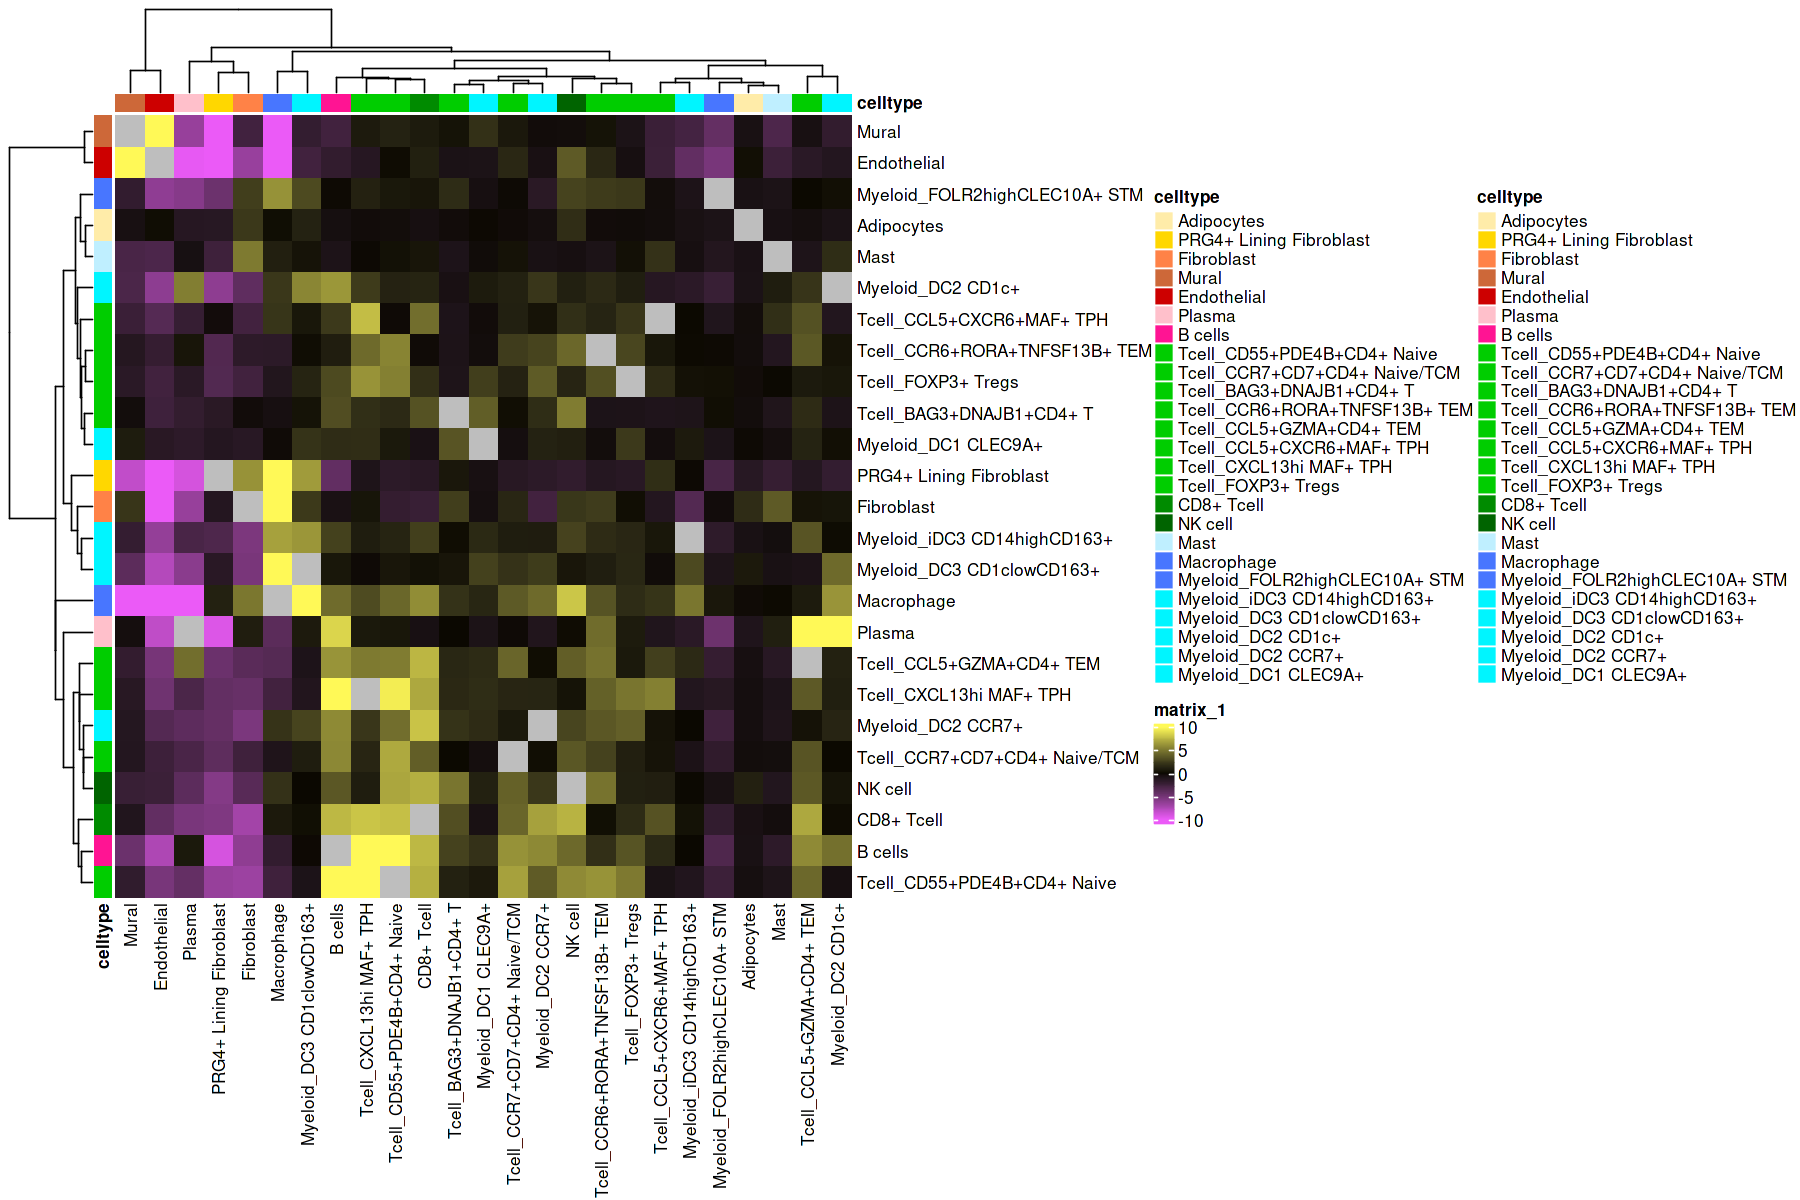

In [39]:
options(repr.plot.width=15, repr.plot.height=10)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
#data[data > 10] <- 10
#data[data < -10] <- -10
pheatmap(
  mat = data,
  border_color = NA,
  color = colorRamp2(c(-10, 0, 10), c("#EB5AF7","#0B0801","#FFF957")),
  show_rownames = TRUE,
  show_colnames = TRUE,
    annotation_col = annotation_col, annotation_colors = metacols, annotation_row=annotation_row,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  fontsize = 10,
  fontsize_row = 10)


In [40]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$index_type%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')),]

In [41]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$type%in%c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')),]

In [42]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [43]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("Myeloid")
annotation_col$Myeloid <- as.ordered(factor(annotation_col$Myeloid, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$Myeloid
#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("CD4_Tcell")
annotation_row$CD4_Tcell <- as.ordered(factor(annotation_row$CD4_Tcell, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$CD4_Tcell

In [44]:
#Set up colour scheme
metacols <- list(
  CD4_Tcell = cols,
    Myeloid = cols
)


## Visualize

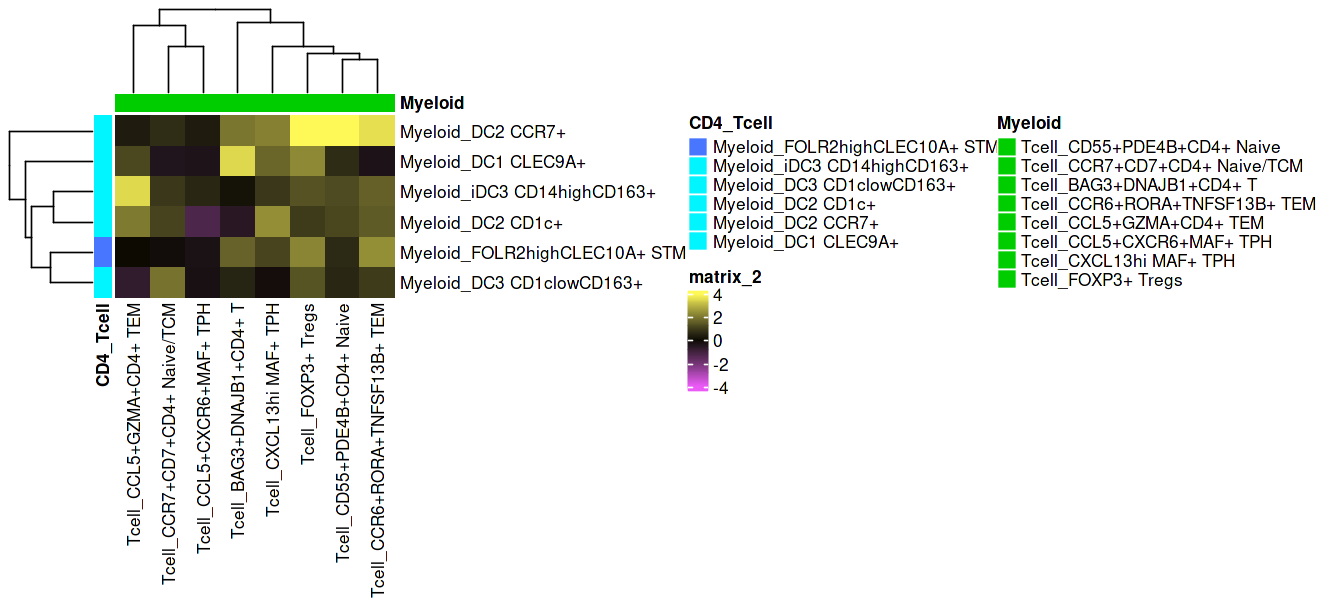

In [45]:
options(repr.plot.width=11, repr.plot.height=5)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
#data[data > 4] <- 4
#data[data < -4] <- -4
pheatmap(
  mat = data,
  border_color = NA,
  color = colorRamp2(c(-4, 0, 4), c("#EB5AF7","#0B0801","#FFF957")),
            annotation_col = annotation_col, annotation_colors = metacols, annotation_row=annotation_row,
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  fontsize = 10,
  fontsize_row = 10)


In [46]:
#Filter non-significant colocalization results 
coloc_res_activeRA_sig <- coloc_res_activeRA[which(coloc_res_activeRA$pval<=0.05),]

In [47]:
#Keep only columns of interest
fov_coloc_new <- data.frame(coloc_res_activeRA_sig$index_type, 
                              coloc_res_activeRA_sig$type,
                              coloc_res_activeRA_sig$zscore)
  colnames(fov_coloc_new) <- c("index_type","type","zscore")
head(fov_coloc_new)

,index_type,type,zscore
,<ord>,<ord>,<dbl>
1,Fibroblast,Macrophage,11.130800
2,Fibroblast,Mast,3.774962
3,Fibroblast,Tcell_BAG3+DNAJB1+CD4+ T,2.522426
4,Fibroblast,Tcell_CCR6+RORA+TNFSF13B+ TEM,2.438962
5,Fibroblast,Myeloid_DC3 CD1clowCD163+,2.268017
6,Fibroblast,NK cell,2.162860


In [48]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [49]:
head(fov_coloc_wide)

,Adipocytes,Fibroblast,Mural,Endothelial,Plasma,B cells,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_BAG3+DNAJB1+CD4+ T,Tcell_CCR6+RORA+TNFSF13B+ TEM,⋯,Tcell_FOXP3+ Tregs,CD8+ Tcell,NK cell,Mast,Macrophage,Myeloid_iDC3 CD14highCD163+,Myeloid_DC3 CD1clowCD163+,Myeloid_DC2 CD1c+,Myeloid_DC2 CCR7+,Myeloid_DC1 CLEC9A+
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adipocytes,NA,2.222960,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,1.717169,NA,NA,NA,NA,NA,NA,NA
PRG4+ Lining Fibroblast,NA,6.098093,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,14.23178,NA,6.450672,NA,NA,NA
Fibroblast,1.667608,NA,2.101516,NA,NA,NA,NA,NA,2.522426,2.438962,⋯,NA,NA,2.162860,3.774962,11.13080,NA,2.268017,NA,NA,NA
Mural,NA,NA,NA,49.49175,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.847172
Endothelial,NA,NA,65.258933,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,3.783169,NA,NA,NA,NA,NA,NA,NA
Plasma,NA,NA,NA,NA,NA,8.689675,NA,NA,NA,4.540657,⋯,NA,NA,NA,NA,NA,NA,NA,17.89129,NA,NA


In [50]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("celltype")
annotation_col$celltype <- as.ordered(factor(annotation_col$celltype, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$celltype
#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("celltype")
annotation_row$celltype <- as.ordered(factor(annotation_row$celltype, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$celltype

In [51]:
#Set up colour scheme
metacols <- list(
  celltype = cols 
)
#Set up colour scheme
metarows <- list(
  celltype = cols
)

## Visualize

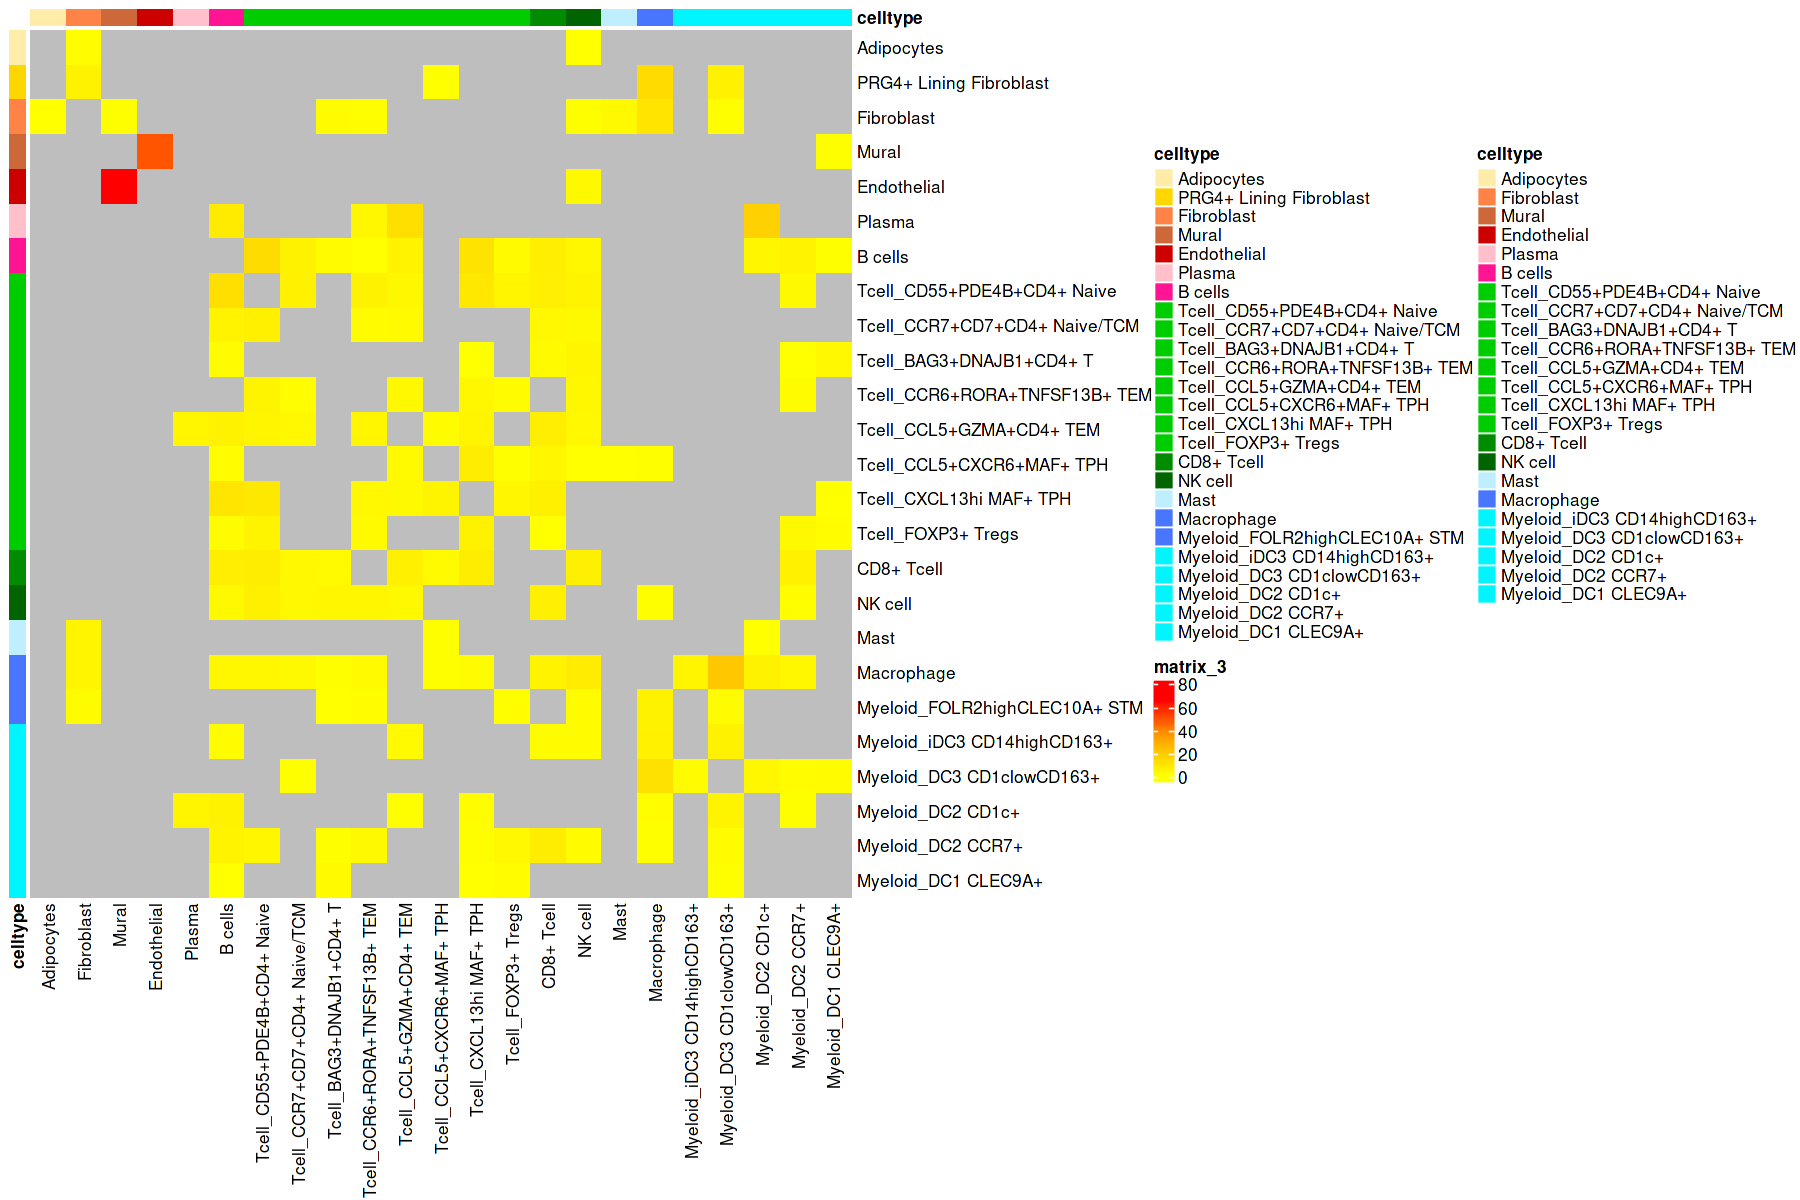

In [52]:
options(repr.plot.width=15, repr.plot.height=10)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
pheatmap(
  mat = data,
  border_color = NA,
  color = colorRampPalette(c("yellow","orange","red"))(8),
        annotation_col = annotation_col, annotation_colors = metacols, annotation_row=annotation_row,
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  fontsize = 10,
  fontsize_row = 10)


In [53]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$index_type%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')),]

In [54]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$type%in%c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')),]

In [55]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [56]:
head(fov_coloc_wide)

,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_BAG3+DNAJB1+CD4+ T,Tcell_CCR6+RORA+TNFSF13B+ TEM,Tcell_CCL5+GZMA+CD4+ TEM,Tcell_CXCL13hi MAF+ TPH,Tcell_FOXP3+ Tregs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Myeloid_FOLR2highCLEC10A+ STM,NA,NA,1.646429,2.386956,NA,NA,2.221455
Myeloid_iDC3 CD14highCD163+,NA,NA,NA,NA,3.525092,NA,NA
Myeloid_DC3 CD1clowCD163+,NA,1.938064,NA,NA,NA,NA,NA
Myeloid_DC2 CD1c+,NA,NA,NA,NA,2.049750,2.392901,NA
Myeloid_DC2 CCR7+,4.621058,NA,1.978091,3.634331,NA,2.151375,4.004173
Myeloid_DC1 CLEC9A+,NA,NA,3.510562,NA,NA,1.709889,2.294022


In [72]:
fov_coloc_wide <- fov_coloc_wide[order(rev(c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM'))),]

In [73]:
head(fov_coloc_wide)

,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_BAG3+DNAJB1+CD4+ T,Tcell_CCR6+RORA+TNFSF13B+ TEM,Tcell_CCL5+GZMA+CD4+ TEM,Tcell_CXCL13hi MAF+ TPH,Tcell_FOXP3+ Tregs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Myeloid_DC1 CLEC9A+,NA,NA,3.510562,NA,NA,1.709889,2.294022
Myeloid_DC2 CD1c+,NA,NA,NA,NA,2.049750,2.392901,NA
Myeloid_DC2 CCR7+,4.621058,NA,1.978091,3.634331,NA,2.151375,4.004173
Myeloid_DC3 CD1clowCD163+,NA,1.938064,NA,NA,NA,NA,NA
Myeloid_FOLR2highCLEC10A+ STM,NA,NA,1.646429,2.386956,NA,NA,2.221455
Myeloid_iDC3 CD14highCD163+,NA,NA,NA,NA,3.525092,NA,NA


In [74]:
#Assign colour for each cluster
fine.type.cols <- c('Myeloid_DC1 CLEC9A+'="#00689A",
                    'Myeloid_DC2 CD1c+'="#43f782",
                    'Myeloid_DC2 CCR7+'="#C776F8",
                    'Myeloid_DC3 CD1clowCD163+'="#F8A640",
                    'Myeloid_iDC3 CD14highCD163+'="#FF6C67",
                    'Myeloid_FOLR2highCLEC10A+ STM'="yellow",
                    
                                 'Myeloid_CLEC10A+ATF3+ STM'='yellow',
                                 'Myeloid_FOLR2highEGR1+ STM'='#27CAF3',
                                 'Myeloid_FOLR2highLYVE1+ STM'="#9aecfa",
                                  'Myeloid_TGFB2+BIRC5+ STM'='orchid1',

                                 'Myeloid_BIRC5+ cycling STM'='magenta1',
                                 'Myeloid_TREM2+ STM'='dodgerblue2',
                                 'Myeloid_TREM2+LPL+ STM'='dodgerblue2',
                                 'Myeloid_SPP1+TREM2low STM'='#FF070A',
                                 'Myeloid_SPP1+ STM'='#FF070A',
                                 'Myeloid_TNF+ICAM1+ STM'='deeppink4',
                                 'Myeloid_ISG15+CXCL10+ STM'='#EB4691',
                                 'Myeloid_CD14highS100A12+ monoSTM'='#EF90D4',
                                 'Myeloid_FCGR3A+ monoSTM'='darkorchid3',
                                 'Myeloid'="royalblue1",
                                 'DC'="turquoise1",
                                 'Fibroblasts'="gold",
                                 'Stromal_PRG4+ lining FLS'="yellow",
                                 'Stromal_PRG4+MMP3+ lining FLS'="orange",
                                 'Stromal_THY1+CXCL12+ FLS'='red',
                                 'Stromal_THY1+COL1A1+ FLS'="pink",
                                 'Stromal_THY1+CD34+MFAP5+ FLS'="green",
                                 'Stromal_THY1+GAS6+CXCL14+ FLS'='dodgerblue1',
                                 'Stromal_CYP1B1+CD52+ FLS'="gold",
                                 'Stromal_C1QA+ FLS doublets'="dodgerblue1", 
                                 
                                 'Stromal_NOTCH3+MCAM+ mural cells'="#B29A42",
                                 'Stromal_SPARC+ capillary EC'="#D0605E",
                                 'Stromal_NOTCH4+ arteriolar EC'="#E49343",
                                 'Stromal_ICAM1+CLU+ venular EC'="#F5C187",
                                 'Stromal_CCL21+LYVE1+ lymphatic EC'="#5878A3",
                                 'Stromal_NA'="#EBCF73",
                "Tcell_CD55+PDE4B+CD4+ Naive"='#AFE1AF',
"Tcell_CCR7+CD7+CD4+ Naive/TCM"="#7CFC00",
'Tcell_BAG3+DNAJB1+CD4+ T'="Purple",
                         'Tcell_CCR6+RORA+TNFSF13B+ TEM'="darkorange",
                                                      'Tcell_CCL5+GZMA+CD4+ TEM'='#FF3131',
                                                                         'Tcell_CCL5+CXCR6+MAF+ TPH'="dodgerblue2",
                                                                         'Tcell_CXCL13hi MAF+ TPH'="darkturquoise",
                                                                         'Tcell_FOXP3+ Tregs'="#FFFF00",
                                                                         'Tcell_ANXA1+HSP+ CD4/CD8'="#EEDE5A",
                                                                         'Tcell_low counts'="#FDBF6F",
                                                                         'Tcell_CCL5+CD8B+CD8A+ Naive'="#FF7F0E",
                                                                         'Tcell_GZMK+CCL5+CD8A+ TEM'="deeppink1",
                                                                         'Tcell_GZMK+CCL5+CD8A+/FLS doublet'="#D62728",
                                                                         'Tcell_KLRB1+GZMK+ NKT'="maroon",
                                                                         'Tcell_MYOM2+ NK/STM doublet'="#FB9A99",
                                                                         'Tcell_MYOM2+ NK'="#CAB2D6",
                                                                         'Tcell_KLRC2+ NK'="#9467BD",
                                                                         'Tcell_XCL1+ NK'="#6A3D9A",
 "Adipocytes"="#ffeca9",
                                 "Plasma"="pink","B cells"="deeppink","Mast"="lightblue1"
                                )

In [75]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("Neighbour")
annotation_col$Neighbour <- as.ordered(factor(annotation_col$Neighbour, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$Neighbour
annotation_col$CD4Tcell <- rownames(annotation_col)

#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("Index")
annotation_row$Index <- as.ordered(factor(annotation_row$Index, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$Index
annotation_row$Myeloid <- rownames(annotation_row)


In [76]:
#Set up colour scheme
metacols <- list(
    Index = cols,
    Neighbour = cols,
    Myeloid = fine.type.cols,
    CD4Tcell = fine.type.cols
)


In [77]:
annotation_row$Index <- as.ordered(factor(annotation_row$Index, levels=c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')))

In [78]:
annotation_col$Neighbour <- as.ordered(factor(annotation_col$Neighbour, levels=c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')))

## Visualize

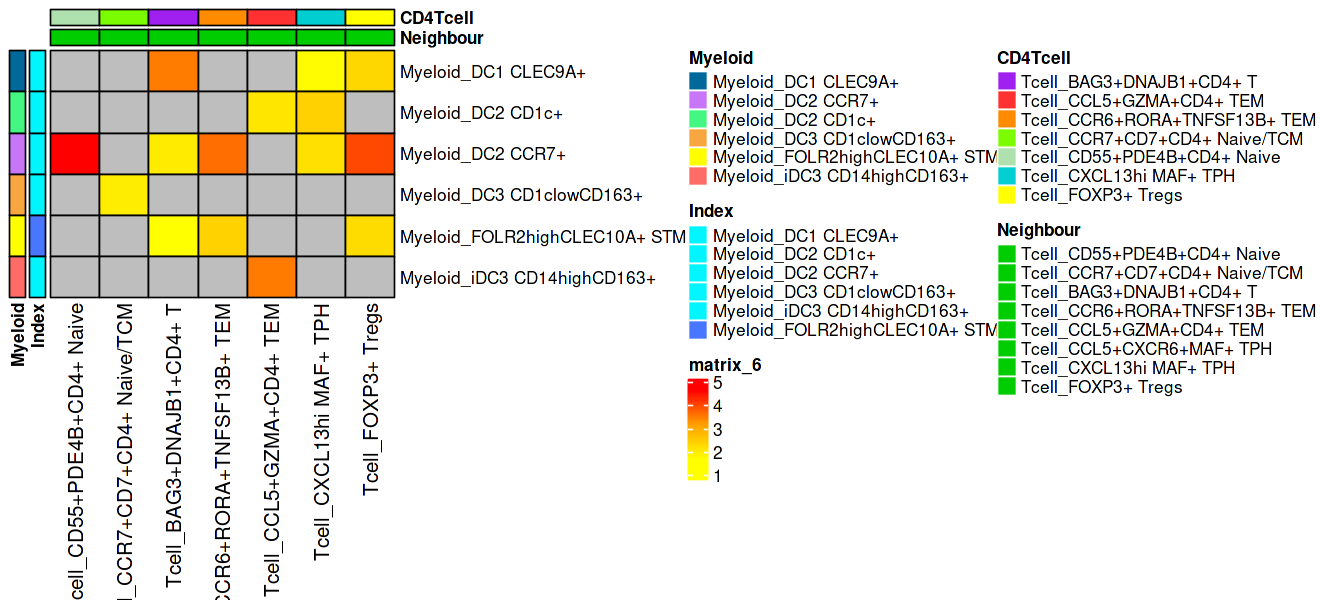

In [79]:
options(repr.plot.width=11, repr.plot.height=5)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
data <- data[,order(annotation_col$Neighbour)]

pheatmap(
  mat = data,
  border_color = "black",
  color = colorRampPalette(c("yellow","orange","red"))(8),
            annotation_col = annotation_col, annotation_colors = metacols, annotation_row=annotation_row,
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  fontsize = 12,
  fontsize_row = 10)


# Active RA - Myeloid rich lining only 

In [597]:
activeRA_cell_ann <- cell_ann[which(cell_ann$Condition=="Active RA"),]
activeRA_lining_cell_ann <- activeRA_cell_ann[which(activeRA_cell_ann$highres.regions=="Myeloid-rich Lining"),]

In [598]:
activeRA_lining_cell_ann <- activeRA_sublining_cell_ann[which(!is.na(activeRA_sublining_cell_ann$dc.t)),]

In [599]:
coloc_res_activeRA = coloc_all_types(
                index_type = unique(activeRA_lining_cell_ann$dc.t),
                coords = activeRA_sublining_cell_ann[, .(x, y)],
                y = activeRA_sublining_cell_ann$dc.t,
                compartments = activeRA_sublining_cell_ann$SampleFOV,
                max_dist = 40, #mean_cell_area x pixelsize
                nperm = 1000 #how much shuffling
        )

Macrophage

Myeloid_iDC3 CD14highCD163+

Tcell_CCL5+CXCR6+MAF+ TPH

Myeloid_DC3 CD1clowCD163+

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking 

In [600]:
head(coloc_res_activeRA)

index_type,type,freq,zscore,pval,fdr,q025,q975
<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Macrophage,Myeloid_DC3 CD1clowCD163+,0.033312061,5.0794026,1.893118e-07,4.543484e-06,0.0224633057,0.028592853
Macrophage,Tcell_CCR6+RORA+TNFSF13B+ TEM,0.001021059,2.3355746,9.756711e-03,2.244044e-01,0.0001276324,0.001021059
Macrophage,Fibroblast,0.013146139,1.9486085,2.567110e-02,5.647641e-01,0.0088066369,0.013273772
Macrophage,NK cell,0.004467135,1.7426737,4.069532e-02,8.546016e-01,0.0022973835,0.004722399
Macrophage,Myeloid_iDC3 CD14highCD163+,0.020165922,-5.1025906,9.999998e-01,1.000000e+00,0.0251435865,0.031142310
Macrophage,Tcell_CCL5+CXCR6+MAF+ TPH,0.001659221,-0.5748515,7.173041e-01,1.000000e+00,0.0010210593,0.002935546


In [601]:
saveRDS(coloc_res_activeRA, "coloc_res_activeRA_AllFOV_myeloid_lining_niche.rds")

In [602]:
#Keep only columns of interest
fov_coloc_new <- data.frame(coloc_res_activeRA$index_type, 
                              coloc_res_activeRA$type,
                              coloc_res_activeRA$zscore)
  colnames(fov_coloc_new) <- c("index_type","type","zscore")
head(fov_coloc_new)

,index_type,type,zscore
,<ord>,<ord>,<dbl>
1,Macrophage,Myeloid_DC3 CD1clowCD163+,5.0794026
2,Macrophage,Tcell_CCR6+RORA+TNFSF13B+ TEM,2.3355746
3,Macrophage,Fibroblast,1.9486085
4,Macrophage,NK cell,1.7426737
5,Macrophage,Myeloid_iDC3 CD14highCD163+,-5.1025906
6,Macrophage,Tcell_CCL5+CXCR6+MAF+ TPH,-0.5748515


In [603]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$index_type%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')),]

In [604]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$type%in%c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')),]

In [605]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [606]:
head(fov_coloc_wide)

,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_BAG3+DNAJB1+CD4+ T,Tcell_CCR6+RORA+TNFSF13B+ TEM,Tcell_CCL5+GZMA+CD4+ TEM,Tcell_CCL5+CXCR6+MAF+ TPH,Tcell_CXCL13hi MAF+ TPH,Tcell_FOXP3+ Tregs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Myeloid_FOLR2highCLEC10A+ STM,-0.2788202,-0.2806617,2.2841447,-0.5488453,0.7498783,0.3219147,-0.5142927,-0.4644483
Myeloid_iDC3 CD14highCD163+,-0.5583925,-0.5877200,-0.7039735,0.4407047,2.5096624,0.6927625,-0.7822042,0.3333542
Myeloid_DC3 CD1clowCD163+,1.0228887,-0.6480662,0.5264726,0.3735630,-0.3773739,-0.4896959,1.2154187,-1.0534266
Myeloid_DC2 CD1c+,-0.2552657,-0.3568515,-0.5159941,-0.4658659,-0.6931261,-0.7571606,-0.4145053,-0.5097117
Myeloid_DC2 CCR7+,-0.1986493,-0.2700969,-0.3305097,-0.3616064,-0.5656791,-0.6667526,-0.3867953,2.3741665
Myeloid_DC1 CLEC9A+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [607]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("Myeloid")
annotation_col$Myeloid <- as.ordered(factor(annotation_col$Myeloid, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$Myeloid
#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("CD4_Tcell")
annotation_row$CD4_Tcell <- as.ordered(factor(annotation_row$CD4_Tcell, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$CD4_Tcell

In [608]:
#Set up colour scheme
metacols <- list(
  CD4_Tcell = cols,
    Myeloid = cols
)


## Visualize

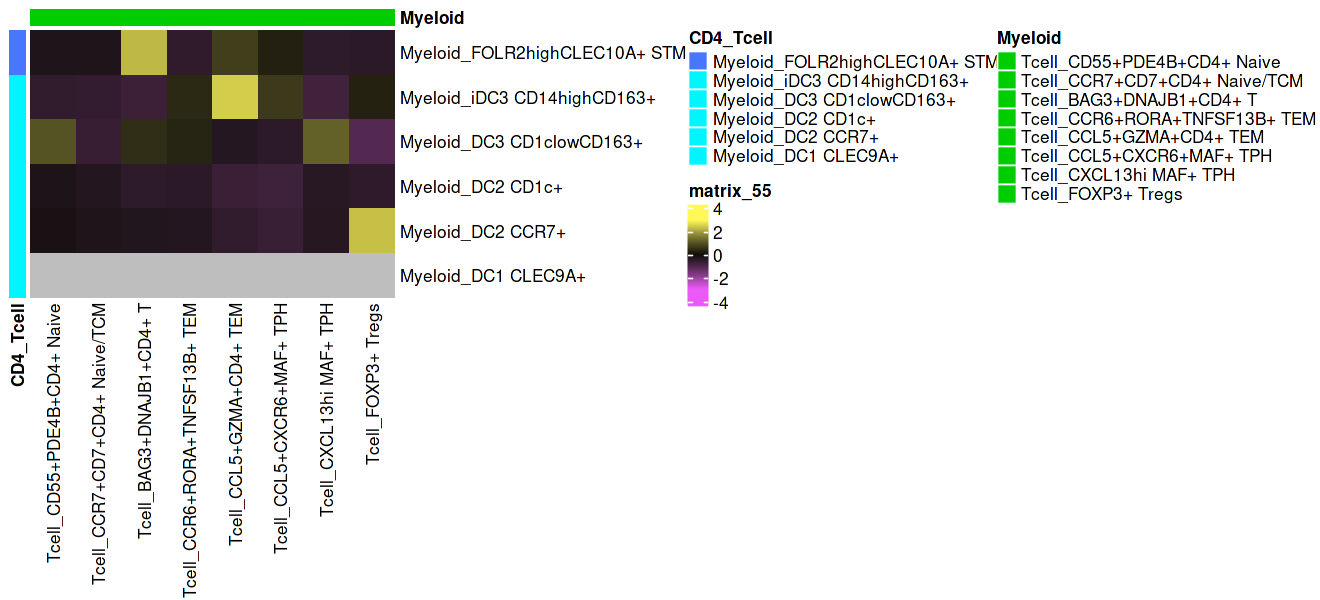

In [609]:
options(repr.plot.width=11, repr.plot.height=5)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
pheatmap(
  mat = data,
  border_color = NA,
  color = colorRamp2(c(-3, 0, 3), c("#EB5AF7","#0B0801","#FFF957")),
                annotation_col = annotation_col, annotation_colors = metacols, annotation_row=annotation_row,

  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  fontsize = 10,
  fontsize_row = 10)


In [610]:
coloc_res_activeRA_sig <- coloc_res_activeRA[which(coloc_res_activeRA$pval<=0.05),]

In [611]:
#Keep only columns of interest
fov_coloc_new <- data.frame(coloc_res_activeRA_sig$index_type, 
                              coloc_res_activeRA_sig$type,
                              coloc_res_activeRA_sig$zscore)
  colnames(fov_coloc_new) <- c("index_type","type","zscore")
head(fov_coloc_new)

,index_type,type,zscore
,<ord>,<ord>,<dbl>
1,Macrophage,Myeloid_DC3 CD1clowCD163+,5.079403
2,Macrophage,Tcell_CCR6+RORA+TNFSF13B+ TEM,2.335575
3,Macrophage,Fibroblast,1.948609
4,Macrophage,NK cell,1.742674
5,Myeloid_iDC3 CD14highCD163+,Tcell_CCL5+GZMA+CD4+ TEM,2.509662
6,Myeloid_iDC3 CD14highCD163+,CD8+ Tcell,1.744309


In [612]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$index_type%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM','Myeloid_DC2 CD1c+_doublet')),]

In [613]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$type%in%c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')),]

In [614]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [615]:
head(fov_coloc_wide)

,Tcell_BAG3+DNAJB1+CD4+ T,Tcell_CCL5+GZMA+CD4+ TEM,Tcell_FOXP3+ Tregs
,<dbl>,<dbl>,<dbl>
Myeloid_FOLR2highCLEC10A+ STM,2.284145,NA,NA
Myeloid_iDC3 CD14highCD163+,NA,2.509662,NA
Myeloid_DC2 CCR7+,NA,NA,2.374167


In [616]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("Neighbour")
annotation_col$Neighbour <- as.ordered(factor(annotation_col$Neighbour, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$Neighbour
annotation_col$CD4Tcell <- rownames(annotation_col)

#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("Index")
annotation_row$Index <- as.ordered(factor(annotation_row$Index, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$Index
annotation_row$Myeloid <- rownames(annotation_row)


In [617]:
#Set up colour scheme
metacols <- list(
    Index = cols,
    Neighbour = cols,
    Myeloid = fine.type.cols,
    CD4Tcell = fine.type.cols
)


In [618]:
annotation_row$Index <- as.ordered(factor(annotation_row$Index, levels=c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')))

In [619]:
annotation_col$Neighbour <- as.ordered(factor(annotation_col$Neighbour, levels=c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')))

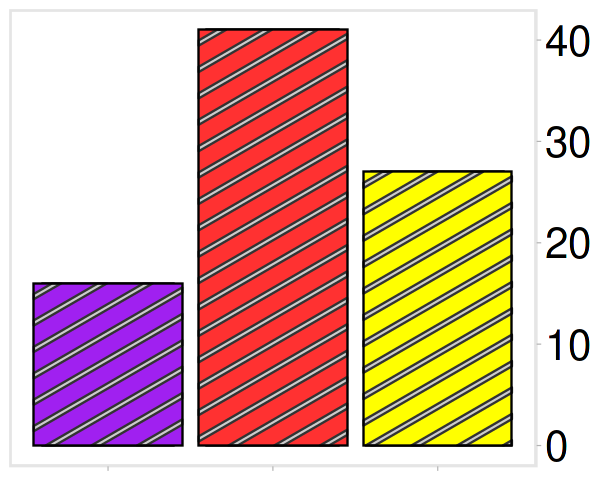

In [644]:
options(repr.plot.width=5, repr.plot.height=4)
t.anno <- table(activeRA_lining_cell_ann[activeRA_lining_cell_ann$fine.types%in%colnames(fov_coloc_wide),"fine.types"])
t.bar <- as.data.frame(t.anno)
t.bar$Pattern <- "1"
t.bar$Var1 <- as.ordered(factor(t.bar$Var1, levels=c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')))
t.bar <- ggplot(data=t.bar, aes(x=Var1, y=Freq, fill=Var1)) +
  geom_bar(stat="identity", width=0.8, color="black") + scale_y_continuous(position = "right") + scale_fill_manual(values=fine.type.cols) + theme_powerpoint() +  geom_col_pattern(color = "black", alpha = 1) + guides(fill=FALSE) + 
theme(axis.text.x=element_blank(), axis.text.y=element_text(size=25, color="black"),axis.title.y=element_blank(),axis.title.x=element_blank()) + ylab("Count")
t.bar

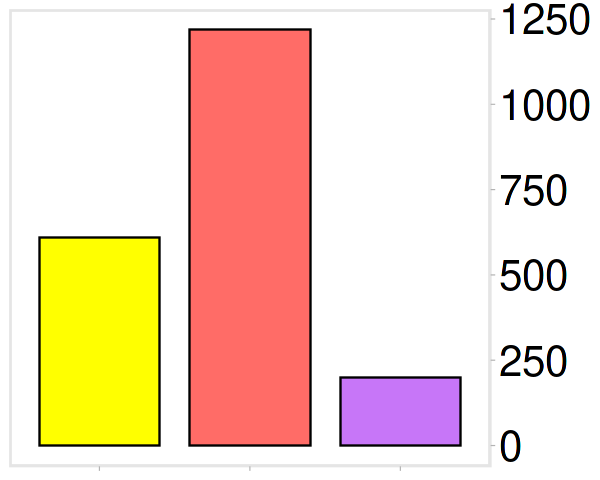

In [621]:
options(repr.plot.width=5, repr.plot.height=4)
dc.anno <- table(activeRA_lining_cell_ann[activeRA_lining_cell_ann$fine.types%in%rownames(fov_coloc_wide),"fine.types"])
dc.bar <- as.data.frame(dc.anno)
dc.bar$Var1 <- as.ordered(factor(dc.bar$Var1, levels=rev(c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM'))))
dc.bar <- ggplot(data=dc.bar, aes(x=Var1, y=Freq, fill=Var1)) +
  geom_bar(stat="identity", width=0.8, color="black") + scale_y_continuous(position = "right") + scale_fill_manual(values=fine.type.cols) + theme_powerpoint() + guides(fill=FALSE) + 
theme(axis.text.x=element_blank(), axis.text.y=element_text(size=25, color="black"),axis.title.y=element_blank(),axis.title.x=element_blank()) + ylab("Count")
dc.bar

## Visualize

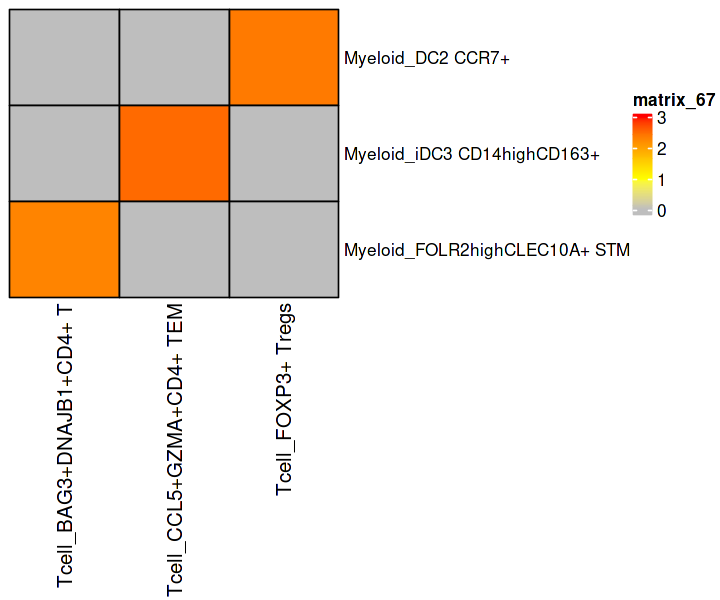

In [635]:
options(repr.plot.width=6, repr.plot.height=5)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
data <- data[order(annotation_row$Index),order(annotation_col$Neighbour)]

pheatmap(
  mat = data,
  border_color = "black",
  color = colorRamp2(c(0,1,3), c("grey","yellow","red")),
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  fontsize = 12,
  fontsize_row = 10)


# Active RA - Lymphoid  only 

In [412]:
activeRA_cell_ann <- cell_ann[which(cell_ann$Condition=="Active RA"),]
activeRA_lymphoid_cell_ann <- activeRA_cell_ann[which(activeRA_cell_ann$highres.regions=="Lymphoid"),]

In [413]:
activeRA_lymphoid_cell_ann <- activeRA_lymphoid_cell_ann[which(!is.na(activeRA_lymphoid_cell_ann$dc.t)),]

In [513]:
coloc_res_activeRA = coloc_all_types(
                index_type = unique(activeRA_lymphoid_cell_ann$dc.t),
                coords = activeRA_lymphoid_cell_ann[, .(x, y)],
                y = activeRA_lymphoid_cell_ann$dc.t,
                compartments = activeRA_lymphoid_cell_ann$SampleFOV,
                max_dist = 40, #mean_cell_area x pixelsize
                nperm = 1000 #how much shuffling
        )

B cells

Mural

Tcell_CD55+PDE4B+CD4+ Naive

Myeloid_DC2 CCR7+

Tcell_CCL5+GZMA+CD4+ TEM

Myeloid_iDC3 CD14highCD163+

Plasma

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, check code

No shuffling is taking place, che

In [514]:
head(coloc_res_activeRA)

index_type,type,freq,zscore,pval,fdr,q025,q975
<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B cells,Plasma,0.047320807,4.5674252,2.468759e-06,5.925022e-05,0.018093250,0.03618650
B cells,Tcell_CXCL13hi MAF+ TPH,0.045929019,2.7042783,3.422647e-03,7.872087e-02,0.024356298,0.04244955
B cells,Tcell_CD55+PDE4B+CD4+ Naive,0.094641614,2.1040405,1.768746e-02,3.891240e-01,0.066109951,0.09326722
B cells,Myeloid_iDC3 CD14highCD163+,0.014613779,1.9695828,2.444310e-02,5.133051e-01,0.004871260,0.01530967
B cells,Mural,0.005567154,-0.6948567,7.564274e-01,1.000000e+00,0.002783577,0.01252610
B cells,Myeloid_DC2 CCR7+,0.022964509,-1.1592424,8.768213e-01,1.000000e+00,0.020163535,0.03827418


In [515]:
saveRDS(coloc_res_activeRA, "coloc_res_activeRA_AllFOV_myeloid_lining_niche.rds")

In [516]:
#Keep only columns of interest
fov_coloc_new <- data.frame(coloc_res_activeRA$index_type, 
                              coloc_res_activeRA$type,
                              coloc_res_activeRA$zscore)
  colnames(fov_coloc_new) <- c("index_type","type","zscore")
head(fov_coloc_new)

,index_type,type,zscore
,<ord>,<ord>,<dbl>
1,B cells,Plasma,4.5674252
2,B cells,Tcell_CXCL13hi MAF+ TPH,2.7042783
3,B cells,Tcell_CD55+PDE4B+CD4+ Naive,2.1040405
4,B cells,Myeloid_iDC3 CD14highCD163+,1.9695828
5,B cells,Mural,-0.6948567
6,B cells,Myeloid_DC2 CCR7+,-1.1592424


In [517]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$index_type%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')),]

In [519]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$type%in%c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')),]

In [520]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [521]:
head(fov_coloc_wide)

,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_BAG3+DNAJB1+CD4+ T,Tcell_CCR6+RORA+TNFSF13B+ TEM,Tcell_CCL5+GZMA+CD4+ TEM,Tcell_CCL5+CXCR6+MAF+ TPH,Tcell_CXCL13hi MAF+ TPH,Tcell_FOXP3+ Tregs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Myeloid_FOLR2highCLEC10A+ STM,-0.2276204,-1.2234485,1.32540729,2.3806080,-1.4340614858,-1.3661981,1.1087395,-0.2156912
Myeloid_iDC3 CD14highCD163+,0.4037114,0.4238635,-1.13514257,0.3793961,0.0004278641,-0.5964639,-0.3190672,0.1224743
Myeloid_DC3 CD1clowCD163+,0.3918185,1.8298607,-0.05605996,-0.4665516,-0.4812423105,0.2615790,-0.2961847,1.4485733
Myeloid_DC2 CD1c+,0.1117905,0.5948429,-0.77366079,-0.9998226,0.3207614735,-1.3003039,0.7232524,-0.7087516
Myeloid_DC2 CCR7+,1.3348296,-1.0987439,-0.23327001,1.5291136,-1.8582619065,-0.5383515,-0.1811566,1.6832201
Myeloid_DC1 CLEC9A+,-0.2660029,-0.6582234,1.62091472,-0.4362175,-0.0021165634,-0.5056667,0.3615522,-0.6397522


In [522]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("Myeloid")
annotation_col$Myeloid <- as.ordered(factor(annotation_col$Myeloid, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$Myeloid
#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("CD4_Tcell")
annotation_row$CD4_Tcell <- as.ordered(factor(annotation_row$CD4_Tcell, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$CD4_Tcell

In [523]:
#Set up colour scheme
metacols <- list(
  CD4_Tcell = cols,
    Myeloid = cols
)


## Visualize

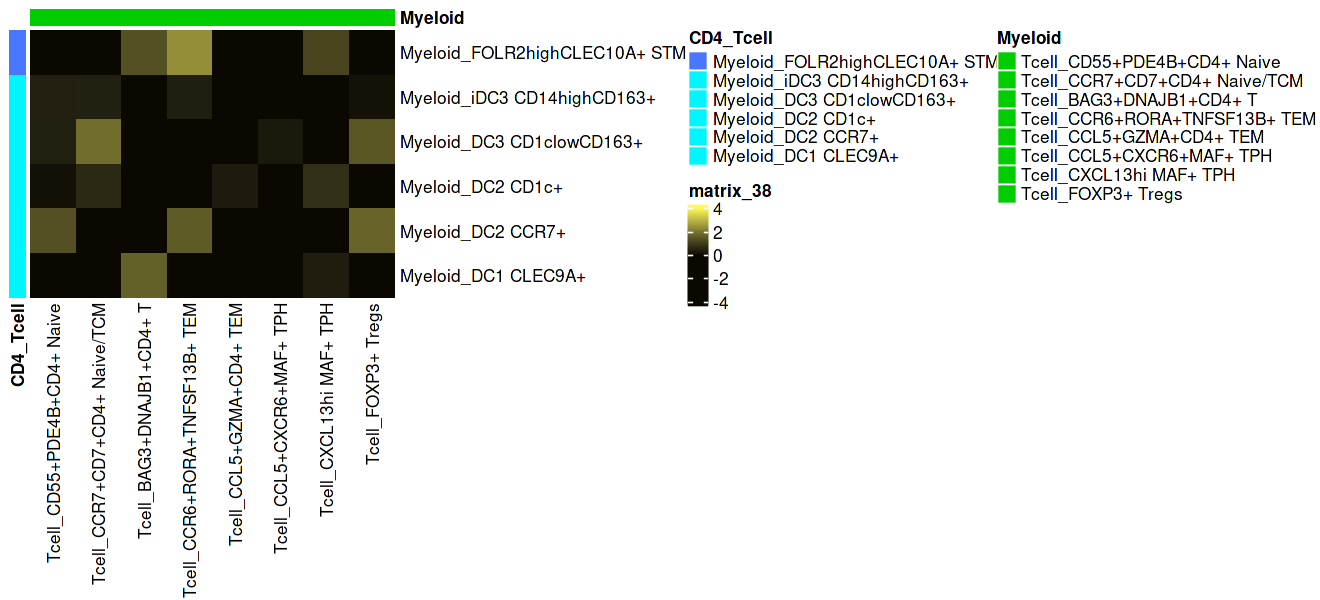

In [524]:
options(repr.plot.width=11, repr.plot.height=5)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
pheatmap(
  mat = data,
  border_color = NA,
  color = colorRamp2(c(-4, 0, 4), c("#0B0801","#0B0801","#FFF957")),
                annotation_col = annotation_col, annotation_colors = metacols, annotation_row=annotation_row,

  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  fontsize = 10,
  fontsize_row = 10)


In [525]:
coloc_res_activeRA_sig <- coloc_res_activeRA[which(coloc_res_activeRA$pval<=0.05),]

In [526]:
#Keep only columns of interest
fov_coloc_new <- data.frame(coloc_res_activeRA_sig$index_type, 
                              coloc_res_activeRA_sig$type,
                              coloc_res_activeRA_sig$zscore)
  colnames(fov_coloc_new) <- c("index_type","type","zscore")
head(fov_coloc_new)

,index_type,type,zscore
,<ord>,<ord>,<dbl>
1,B cells,Plasma,4.567425
2,B cells,Tcell_CXCL13hi MAF+ TPH,2.704278
3,B cells,Tcell_CD55+PDE4B+CD4+ Naive,2.104041
4,B cells,Myeloid_iDC3 CD14highCD163+,1.969583
5,Mural,Myeloid_DC2 CCR7+,3.880820
6,Tcell_CD55+PDE4B+CD4+ Naive,Tcell_CXCL13hi MAF+ TPH,3.310037


In [527]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$index_type%in%c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM','Myeloid_DC2 CD1c+_doublet')),]

In [528]:
fov_coloc_new <- fov_coloc_new[c(fov_coloc_new$type%in%c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')),]

In [529]:
#Change format of dataframe to wide
  fov_coloc_wide <- spread(fov_coloc_new, type, zscore)
  rownames(fov_coloc_wide) <- fov_coloc_wide$index_type
  fov_coloc_wide$index_type <- NULL

In [484]:
head(fov_coloc_wide)

,Tcell_CCR7+CD7+CD4+ Naive/TCM,Tcell_CCR6+RORA+TNFSF13B+ TEM,Tcell_FOXP3+ Tregs
,<dbl>,<dbl>,<dbl>
Myeloid_FOLR2highCLEC10A+ STM,NA,2.380608,NA
Myeloid_DC3 CD1clowCD163+,1.829861,NA,NA
Myeloid_DC2 CCR7+,NA,NA,1.68322


In [537]:
#Fetch metadata
annotation_col <- as.data.frame(colnames(fov_coloc_wide))
colnames(annotation_col) <- c("Neighbour")
annotation_col$Neighbour <- as.ordered(factor(annotation_col$Neighbour, levels=levels(cell_ann$dc.t)))
rownames(annotation_col) <- annotation_col$Neighbour
annotation_col$CD4Tcell <- rownames(annotation_col)

#Fetch metadata
annotation_row <- as.data.frame(rownames(fov_coloc_wide))
colnames(annotation_row) <- c("Index")
annotation_row$Index <- as.ordered(factor(annotation_row$Index, levels=levels(cell_ann$dc.t)))
rownames(annotation_row) <- annotation_row$Index
annotation_row$Myeloid <- rownames(annotation_row)


In [538]:
#Set up colour scheme
metacols <- list(
    Index = cols,
    Neighbour = cols,
    Myeloid = fine.type.cols,
    CD4Tcell = fine.type.cols
)


In [539]:
annotation_row$Index <- as.ordered(factor(annotation_row$Index, levels=c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM')))

In [540]:
annotation_col$Neighbour <- as.ordered(factor(annotation_col$Neighbour, levels=c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')))

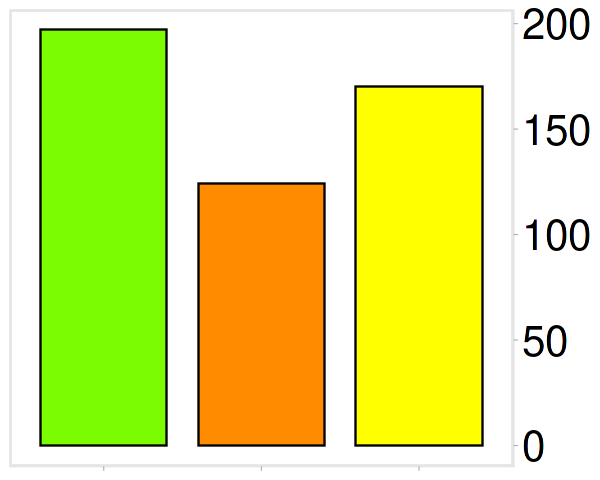

In [552]:
options(repr.plot.width=5, repr.plot.height=4)
t.anno <- table(activeRA_lymphoid_cell_ann[activeRA_lymphoid_cell_ann$fine.types%in%colnames(fov_coloc_wide),"fine.types"])
t.bar <- as.data.frame(t.anno)
t.bar$Var1 <- as.ordered(factor(t.bar$Var1, levels=c("Tcell_CD55+PDE4B+CD4+ Naive",
                                 "Tcell_CCR7+CD7+CD4+ Naive/TCM",
                                
                                 'Tcell_BAG3+DNAJB1+CD4+ T',
                                 'Tcell_CCR6+RORA+TNFSF13B+ TEM',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tc
ell_CCL5+CXCR6+MAF+ TPH',
                                 'Tcell_CXCL13hi MAF+ TPH',
                                 'Tcell_FOXP3+ Tregs')))
t.bar <- ggplot(data=t.bar, aes(x=Var1, y=Freq, fill=Var1)) +
  geom_bar(stat="identity", width=0.8, color="black") + scale_y_continuous(position = "right") + scale_fill_manual(values=fine.type.cols) + theme_powerpoint() + guides(fill=FALSE) + 
theme(axis.text.x=element_blank(), axis.text.y=element_text(size=25, color="black"),axis.title.y=element_blank(),axis.title.x=element_blank()) + ylab("Count")
t.bar

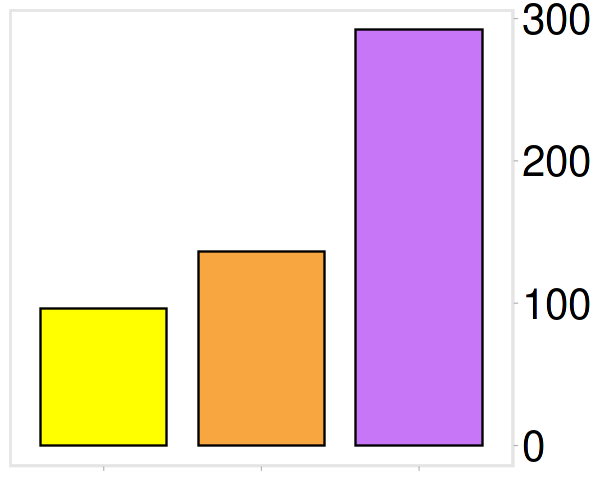

In [551]:
options(repr.plot.width=5, repr.plot.height=4)
dc.anno <- table(activeRA_lymphoid_cell_ann[activeRA_lymphoid_cell_ann$fine.types%in%rownames(fov_coloc_wide),"fine.types"])
dc.bar <- as.data.frame(dc.anno)
dc.bar$Var1 <- as.ordered(factor(dc.bar$Var1, levels=rev(c('Myeloid_DC1 CLEC9A+',
                                 'Myeloid_DC2 CD1c+',
                                 'Myeloid_DC2 CCR7+',
                                 'Myeloid_DC3 CD1clowCD163+',
                                 'Myeloid_iDC3 CD14highCD163+',
                                 'Myeloid_FOLR2highCLEC10A+ STM'))))
dc.bar <- ggplot(data=dc.bar, aes(x=Var1, y=Freq, fill=Var1)) +
  geom_bar(stat="identity", width=0.8, color="black") + scale_y_continuous(position = "right") + scale_fill_manual(values=fine.type.cols) + theme_powerpoint() + guides(fill=FALSE) + 
theme(axis.text.x=element_blank(), axis.text.y=element_text(size=25, color="black"),axis.title.y=element_blank(),axis.title.x=element_blank()) + ylab("Count")
dc.bar

## Visualize

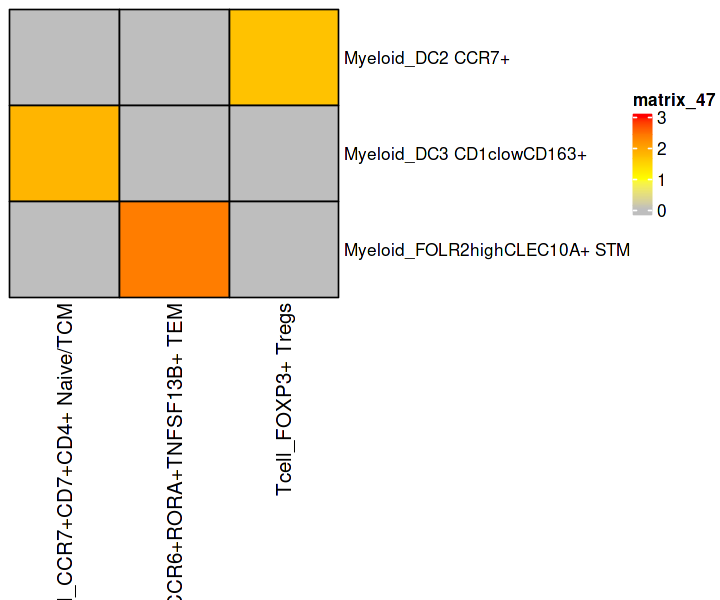

In [558]:
options(repr.plot.width=6, repr.plot.height=5)
library(pheatmap)
data <- as.matrix(fov_coloc_wide)
data[is.na(data)] <- 0
data <- data[order(annotation_row$Index),order(annotation_col$Neighbour)]

pheatmap(
  mat = data,
  border_color = "black",
  color = colorRamp2(c(0,1,2,3), c("grey","yellow","orange","red")),
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  fontsize = 12,
  fontsize_row = 10) 


In [535]:
annotation_col$Neighbour

NULL